In [2]:
# Using pandas to process data
from collections import Counter
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import pearsonr

from utils.data_util import load_bj_aq_data, generate_model_data
# from utils.plot_util import plot_station, plot_stations

%load_ext autoreload
%autoreload 2

### 1. 数据载入

使用处理过的数据，不使用原始数据。

In [3]:
bj_aq_stations_merged = pd.read_csv("./data/bj_aq_data.csv")

In [4]:
# 去掉缺失值所在的行
for index in bj_aq_stations_merged.index :
    if pd.isnull(bj_aq_stations_merged.loc[index]).any():
        bj_aq_stations_merged.drop([index], inplace=True)

In [5]:
bj_aq_stations_merged.shape

(10853, 211)

### 2. 相同特征不同站点之间的相关性

In [6]:
# 站点的具体位置
station_locations = pd.read_excel("./KDD_CUP_2018/Beijing/location/Beijing_AirQuality_Stations_locations.xlsx")
station_locations.head()

,stationName,longitude,latitude
0,dongsi_aq,116.417,39.929
1,tiantan_aq,116.407,39.886
2,guanyuan_aq,116.339,39.929
3,wanshouxigong_aq,116.352,39.878
4,aotizhongxin_aq,116.397,39.982


In [6]:
def caculate_distance(station_1, station_2, station_locations):
    '''
    station_1, station_2 : names of two stations
    station_locations : a dataframe of "stationName", "longitude", "latitude"
    '''
    location_1 = station_locations[station_1+"_aq" == station_locations["stationName"]]
    location_2 = station_locations[station_2+"_aq" == station_locations["stationName"]]
    dis = np.sqrt((location_1["longitude"].values[0] - location_2["longitude"].values[0])**2 + 
                  (location_1["latitude"].values[0] - location_2["latitude"].values[0])**2)
    return dis

In [7]:
def caculate_r_distance_relations(dataframe, feature):
    '''
    dataframe : dataframe with all data.
    feature : feature that you want to compare.
    '''
    features = [name for name in dataframe.columns if feature in name]
    df = dataframe[features]
    
    relations = pd.DataFrame(columns=["station_1", "station_2", "r", "distance"])
    for i in range(len(features)-1):
        for j in range(i+1,len(features)):
            station_1 = features[i].split("_")[0]
            station_2 = features[j].split("_")[0]
            ts_station_1 = df[features[i]]
            ts_station_2 = df[features[j]]
            r = pearsonr(ts_station_1, ts_station_2)[0]
            distance = caculate_distance(station_1, station_2, station_locations)
            s = pd.Series({"station_1":station_1, "station_2":station_2, "r":r, "distance":distance})
            relations = relations.append(s,ignore_index=True)
    
    # 按照相关系数降序排序
    relations = relations.sort_values(by=['r'], ascending=False)

    plt.subplot(2,1,1)
    plt.plot(range(len(relations)), relations['r']);
    plt.subplot(2,1,2)
    plt.plot(range(len(relations)), relations['distance']);

    # “相关系数的降低” 与 “站点之间的距离” 存在一定的正相关关系
    # “距离” 与 “相关性” 存在负相关关系
    # print("The range of pearsonr between stations of feature %s are between %d and %d" %(feature, relations["r"].values.min(), relations["r"].values.max()))
    
    r = pearsonr(relations["r"].values, relations['distance'].values)[0]
    # print("r = ", pearsonr(relations["r"].values, relations['distance'].values)[0])
    
    return relations, r

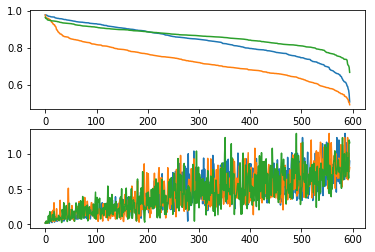

In [8]:
for feature in ["PM2.5", "PM10", "O3"]:
    relations, r = caculate_r_distance_relations(bj_aq_stations_merged, feature)

## 3. 空气质量的“天”的周期性

In [10]:
bj_aq_stations_merged.set_index("time", inplace=True)

In [12]:
bj_aq_stations_merged['new'] = bj_aq_stations_merged.index
bj_aq_stations_merged['new'] = pd.to_datetime(bj_aq_stations_merged['new'])

In [32]:
def feature_trend_in_a_day(bj_aq_stations_merged, feature):
    
    df = bj_aq_stations_merged[["new", feature]]
    # initial values
    d = datetime.timedelta(hours=24)
    t_start = datetime.datetime(2017,1,2,0,0,0)
    t_end = datetime.datetime(2017,1,3,0,0,0)

    all_days = []
    all_days_dfs = []
    for i in range(445):
        df = bj_aq_stations_merged[["new", feature]]
        df_part = df[df['new'] < t_end]
        df_part = df_part[df_part['new'] >= t_start]

        all_days.append(df_part[feature].values)
        all_days_dfs.append(df_part)
        t_start += d
        t_end += d

    bias_all_days = []
    for day in all_days:
        if len(day) == 24 : 
            init = day[0]
            bias_day = [i - init for i in day]
            bias_all_days.append(bias_day)

    # for bias_all_day in bias_all_days:
    #     plt.plot(bias_all_day)

    bias_all_days = np.array(bias_all_days)
    day = np.mean(bias_all_days, axis=0)
    plt.plot(day);

In [39]:
bj_aq_stations_merged.columns

Index(['yongledian_aq_PM2.5', 'yongledian_aq_PM10', 'yongledian_aq_NO2',
       'yongledian_aq_CO', 'yongledian_aq_O3', 'yongledian_aq_SO2',
       'wanliu_aq_PM2.5', 'wanliu_aq_PM10', 'wanliu_aq_NO2', 'wanliu_aq_CO',
       ...
       'aotizhongxin_aq_CO', 'aotizhongxin_aq_O3', 'aotizhongxin_aq_SO2',
       'pingchang_aq_PM2.5', 'pingchang_aq_PM10', 'pingchang_aq_NO2',
       'pingchang_aq_CO', 'pingchang_aq_O3', 'pingchang_aq_SO2', 'new'],
      dtype='object', length=211)

In [45]:
pm25 = [i for i in bj_aq_stations_merged.columns if "PM2.5" in i ]
pm10 = [i for i in bj_aq_stations_merged.columns if "PM10" in i ]
O3 = [i for i in bj_aq_stations_merged.columns if "O3" in i ]
NO2 = [i for i in bj_aq_stations_merged.columns if "NO2" in i ]
SO2 = [i for i in bj_aq_stations_merged.columns if "SO2" in i ]
CO = [i for i in bj_aq_stations_merged.columns if "CO" in i ]

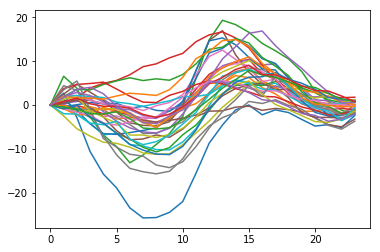

In [42]:
for feature in pm25:
    feature_trend_in_a_day(bj_aq_stations_merged, feature)

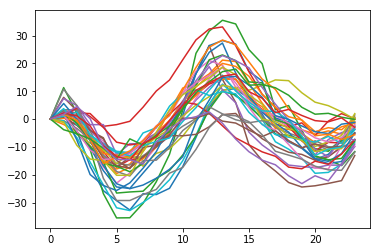

In [43]:
for feature in pm10:
    feature_trend_in_a_day(bj_aq_stations_merged, feature)

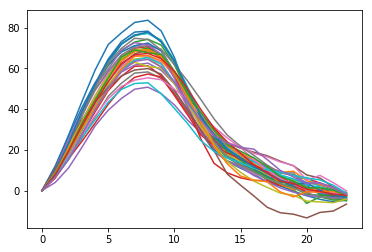

In [44]:
for feature in O3:
    feature_trend_in_a_day(bj_aq_stations_merged, feature)

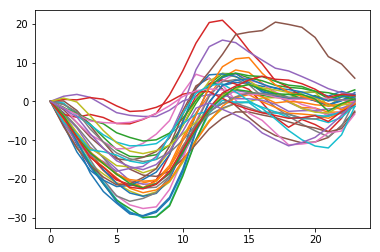

In [46]:
for feature in NO2:
    feature_trend_in_a_day(bj_aq_stations_merged, feature)

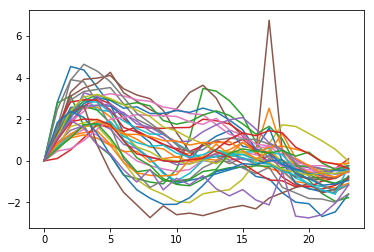

In [47]:
for feature in SO2:
    feature_trend_in_a_day(bj_aq_stations_merged, feature)

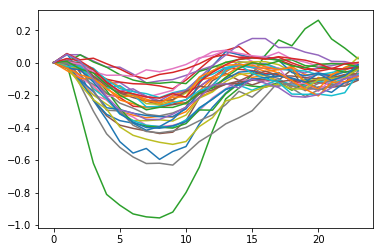

In [48]:
for feature in CO:
    feature_trend_in_a_day(bj_aq_stations_merged, feature)

### Changelog
- 0424 v0
    - 不同站点之间，相同参数之间有 0.5-1 之间的相关性，属于比较强的相关性
        - 但是0.9以下的相关性，如果只使用它们中的一个代表全部肯定是不行的，因此肯定要对各自站点分别建模
        - 建模方式可以是
            - 单站点建模
            - 多站点共同建模
    - 特征在一天内的变化特征
        - 不同的特征有明显不同的变化趋势，可以考虑
            - 单特征模型
            - 多特征模型